In [1]:
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torchvision
import math
import time
from torch import optim

In [2]:
cifar10 = load_dataset('cifar10')

In [3]:
def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

In [4]:
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


#################################################################################
#               Embedding Layers for Timesteps and Class Labels                 #
#################################################################################

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb




#################################################################################
#                                 Core DiT Model                                #
#################################################################################

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x





#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [5]:
class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=3,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
        learn_sigma=False,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        #self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        #nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        #y = self.y_embedder(y, self.training)    # (N, D)
        c = t                                 # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

In [6]:
unet = DiT(depth=3, hidden_size=768, patch_size=2, num_heads=12).cuda()

In [7]:
from galore_torch import GaLoreAdamW

In [8]:
model_parameters = list(unet.named_parameters())

galore_params = []
non_galore_params = []

for name, param in model_parameters:
    if param.ndim == 2:
        if 'attn' in name or 'mlp' in name or 'linear' in name:
            galore_params.append(param)
        else:
            non_galore_params.append(param)
    else:
        non_galore_params.append(param)


In [9]:
param_groups = [
    {
        'params': non_galore_params
    },
    {
        'params': galore_params,
        'rank': 64,
        'update_proj_gap': 50,
        'scale': 0.10,
        'proj_type': 'std',
        'use_randomized_svd': True  # Enable randomized SVD
    }
]

In [10]:
batch_size = 128
optimizer = GaLoreAdamW(param_groups, lr=1e-4)

/teamspace/studios/this_studio/Galore/galore_torch/adamw.py:49: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
n_steps = 1000
beta = torch.linspace(0.0001, 0.02, n_steps).cuda() # 0.04 original
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):

    eps=torch.randn(x0.shape).cuda()
    alpha_bar_t = alpha_bar[t-1]
    xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1-alpha_bar_t) * eps
    return xt , eps


def calc_loss(unet: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    t=torch.randint(1,n_steps,(len(x),1,1,1)).cuda()
    x_t,eps = q_xt_x0(x,t)
    t=t.reshape(len(x),)
    eps_t = unet(x_t,t)
    loss = F.mse_loss(eps_t, eps)
    return loss

In [9]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

Files already downloaded and verified


In [10]:
def p_xt(xt, noise, t):

    alpha_t = alpha[t-1]
    alpha_bar_t = alpha_bar[t-1]
    if t>1:
      z = torch.randn(xt.shape).cuda()
    else:
      z = torch.zeros(xt.shape).cuda()
    sigma_t = torch.sqrt(beta[t-1])
    x_tm1 = (  xt - ( noise*(1-alpha_t)/torch.sqrt(1-alpha_bar_t) )  ) / (torch.sqrt(alpha_t))  + sigma_t*z
    return x_tm1

1 (483.35930490493774s): 0.10161039233207703
2 (968.6477863788605s): 0.06703536957502365
3 (1454.3013956546783s): 0.05139352008700371
4 (1939.6782500743866s): 0.06227579712867737
5 (2425.475705385208s): 0.05618468299508095


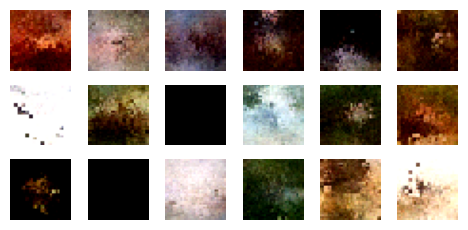

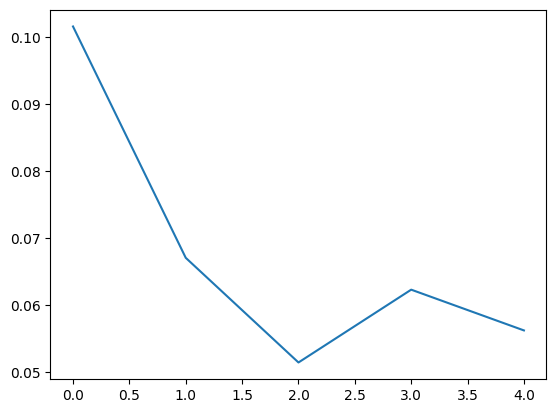

In [14]:
data_loader=torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
t0 = time.time()
losses = []
for i_epoch in range (5) :
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        loss = calc_loss(unet,(2*data[0]-1).cuda())
        loss.backward()
        optimizer.step()
        
        
    print(f"{i_epoch+1} ({time.time() - t0}s): {loss.item()}")
    losses.append(loss.item())
        
        
    if (i_epoch + 1) % 5 == 0:
        torch.manual_seed(42)
        x = torch.randn(18, 3, 32, 32).cuda()
        ims = []
        for i in range(n_steps):
            t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
            with torch.no_grad():
                pred_noise = unet(x.float(), t.unsqueeze(0))
                x = p_xt(x, pred_noise, t.unsqueeze(0))
                
        for i in range(18):
            ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))
            
        num_images = len(ims)
        cols = 6 
        rows = 3
        plt.figure(figsize=(cols*0.8, rows*0.8))
        for i, im in enumerate(ims):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(im)
            plt.axis('off')
        plt.tight_layout()
        #plt.savefig(f'/kaggle/working/dit_images_epoch_{i_epoch + 1}.png')
        plt.show()
        plt.close()

#torch.save(unet.state_dict(), '/kaggle/working/dit_model.pth')         
plt.plot(losses)

1 (505.1472294330597s): 0.12723200023174286
2 (1009.9818363189697s): 0.0531897135078907
3 (1514.7192070484161s): 0.08220622688531876
4 (2019.6214408874512s): 0.04753398522734642
5 (2524.7918779850006s): 0.05760698765516281


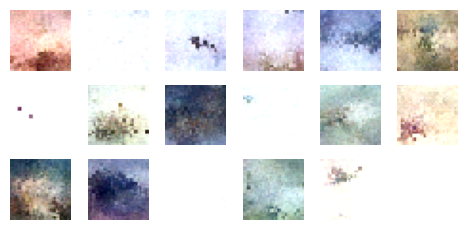

6 (3088.910980463028s): 0.04625098779797554


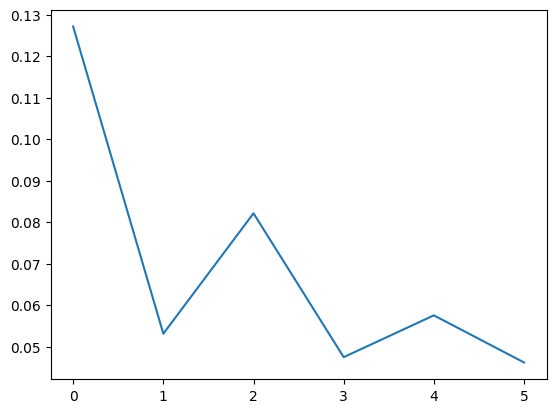

In [18]:
data_loader=torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
t0 = time.time()
losses = []
for i_epoch in range (6) :
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        loss = calc_loss(unet,(2*data[0]-1).cuda())
        loss.backward()
        optimizer.step()
        
        
    print(f"{i_epoch+1} ({time.time() - t0}s): {loss.item()}")
    losses.append(loss.item())
        
        
    if (i_epoch + 1) % 5 == 0:
        torch.manual_seed(42)
        x = torch.randn(18, 3, 32, 32).cuda()
        ims = []
        for i in range(n_steps):
            t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
            with torch.no_grad():
                pred_noise = unet(x.float(), t.unsqueeze(0))
                x = p_xt(x, pred_noise, t.unsqueeze(0))
                
        for i in range(18):
            ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))
            
        num_images = len(ims)
        cols = 6 
        rows = 3
        plt.figure(figsize=(cols*0.8, rows*0.8))
        for i, im in enumerate(ims):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(im)
            plt.axis('off')
        plt.tight_layout()
        #plt.savefig(f'/kaggle/working/dit_images_epoch_{i_epoch + 1}.png')
        plt.show()
        plt.close()

#torch.save(unet.state_dict(), '/kaggle/working/dit_model.pth')         
plt.plot(losses)

In [19]:
def print_parameter_summary(model, galore_params_set):
    print(f"{'Parameter Name':60} {'Shape':20} {'Num Params':15} {'In GaLore Params'}")
    print('-' * 110)
    total_params = 0
    total_galore_params = 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        in_galore = 'Yes' if param in galore_params_set else 'No'
        if in_galore == 'Yes':
            total_galore_params += num_params
        print(f"{name:60} {str(param.shape):20} {num_params:15} {in_galore}")
    print('-' * 110)
    print(f"Total parameters: {total_params}")
    print(f"Total GaLore parameters: {total_galore_params}")
    print(f"Total non-GaLore parameters: {total_params - total_galore_params}")


galore_params_set = set(galore_params)
print_parameter_summary(unet, galore_params_set)


Parameter Name                                               Shape                Num Params      In GaLore Params
--------------------------------------------------------------------------------------------------------------
pos_embed                                                    torch.Size([1, 256, 768])          196608 No
x_embedder.proj.weight                                       torch.Size([768, 3, 2, 2])            9216 No
x_embedder.proj.bias                                         torch.Size([768])                768 No
t_embedder.mlp.0.weight                                      torch.Size([768, 256])          196608 Yes
t_embedder.mlp.0.bias                                        torch.Size([768])                768 No
t_embedder.mlp.2.weight                                      torch.Size([768, 768])          589824 Yes
t_embedder.mlp.2.bias                                        torch.Size([768])                768 No
blocks.0.attn.qkv.weight                          

In [8]:
from torch import optim
batch_size = 128
lr = 1e-4
#lr = 0.001
optim = torch.optim.AdamW(unet.parameters(), lr=lr)

1 (489.82619547843933s): 0.04766647517681122
2 (982.440865278244s): 0.032219089567661285
3 (1475.0693593025208s): 0.03369387984275818
4 (1967.7976355552673s): 0.04685093089938164
5 (2460.3740882873535s): 0.03828401863574982


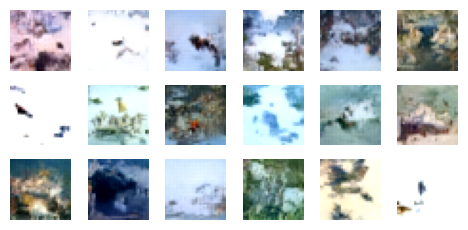

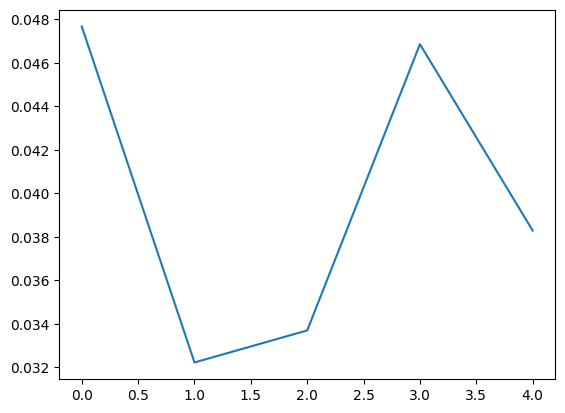

In [12]:
data_loader=torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
t0 = time.time()
losses = []
for i_epoch in range (5) :
    total_loss = 0
    for data in data_loader:
        optim.zero_grad()
        loss = calc_loss(unet,(2*data[0]-1).cuda())
        loss.backward()
        optim.step()
        
        
    print(f"{i_epoch+1} ({time.time() - t0}s): {loss.item()}")
    losses.append(loss.item())
        
        
    if (i_epoch + 1) % 5 == 0:
        torch.manual_seed(42)
        x = torch.randn(18, 3, 32, 32).cuda()
        ims = []
        for i in range(n_steps):
            t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
            with torch.no_grad():
                pred_noise = unet(x.float(), t.unsqueeze(0))
                x = p_xt(x, pred_noise, t.unsqueeze(0))
                
        for i in range(18):
            ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))
            
        num_images = len(ims)
        cols = 6 
        rows = 3
        plt.figure(figsize=(cols*0.8, rows*0.8))
        for i, im in enumerate(ims):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(im)
            plt.axis('off')
        plt.tight_layout()
        #plt.savefig(f'/kaggle/working/dit_images_epoch_{i_epoch + 1}.png')
        plt.show()
        plt.close()

#torch.save(unet.state_dict(), '/kaggle/working/dit_model.pth')         
plt.plot(losses)